# **Sim-SOENs**
## ***A Simulator for Superconducting Optoelectronic Networks***

# Introduction: *What are SOENs?*
<!-- ![ title](img/wafer_tilted.png) ![ title](img/neuron_3d.png) ![ title](img/neuron_complex.png) -->
![ title](../img/wafers_circuits.png)
 - SOENs are an emerging neuromorphic hardware that leverage light-speed communication for brain level scalability.
 - SOENs are spiking neural networks
   - Spikes --> photons
   - Neurons --> superconducting circuits
   - Transmitters --> silicon diode light source
 - SOEN neurons are neuro-inspired, with sophisticated dendritic arbors for single-neuron computations


![ title](../img/neuron_complex.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from sim_soens.super_input import SuperInput
from sim_soens.soen_sim import network
from sim_soens.super_node import SuperNode
from sim_soens.soen_plotting import raster_plot, activity_plot

## Part 1: What is a SOEN Neuron?

A SOEN Neuron consists of three main components:
 - **Synapse**     = Single Photon Detector (SPD)
 - **Dendrite**   = Superconducting Quantum Interference Device (SQUID) as the *recieving loop* with an L/R circuit *integration loop*
   - *Somatic Dendrite*
     - Acts as the cell-body
     - Integrates signal from a preceding dendritic arbor, or directly from a synapse
     - When threshold is reached, activates transmitter circuit and couples flux to refractory dendrite
   - *Refractory Dendrite* (not shown here)
     - inhibits somatic dendrite through coupled flux 
   - *Arbor Dendrite* (not shown here)
     - An arbor can consist of arbirtrary multi-dendrite structures
     - All roads lead to soma
 - **Transmitter** = hTron coupled to a silicon light emitting diode which routes photonic output to downstream synapses via waveguides

![ title](../img/monosynaptic.png)

In sim-soens, conjuring up a neuron is best done through the `SuperNode` class
 - A node is an object that contains all components of a neuron
 - Hosts meta-data about the neuron
 - Stores post-simulation data about the neuron's activity
 - By default, a minimal neuron is created
   - One synapse
   - One soma (a dendrite with a transmitter and coupled refractory dendrite)

In [2]:
# call an instance of the SuperNode class
node = SuperNode()

# read about your node
node.parameter_print()


SOMA:
 ib_n = 1.802395858835221
 tau_ni = 50
 beta_ni = 628.3185307179587
 loops_present = ri
 s_th = 0.5
 synaptic_inputs = ['rand_neuron_77132_syn0']
 dendritic_inputs = ['rand_neuron_77132__dend_refraction']

REFRACTORY DENDRITE:
 ib_ref = 1.7
 tau_ref = 50
 beta_ref = 628.3185307179587
 loops_present = ri
 dendritic_inputs = []

DENDRITIC ARBOR:
  empty


### Input
 - Input is generally provided in the form of spike trains (spike = incoming photon)
 - Creating input is best done through the `SuperInput` class
   - Random
   - Defined
   - MNIST
   - Saaccade MNIST

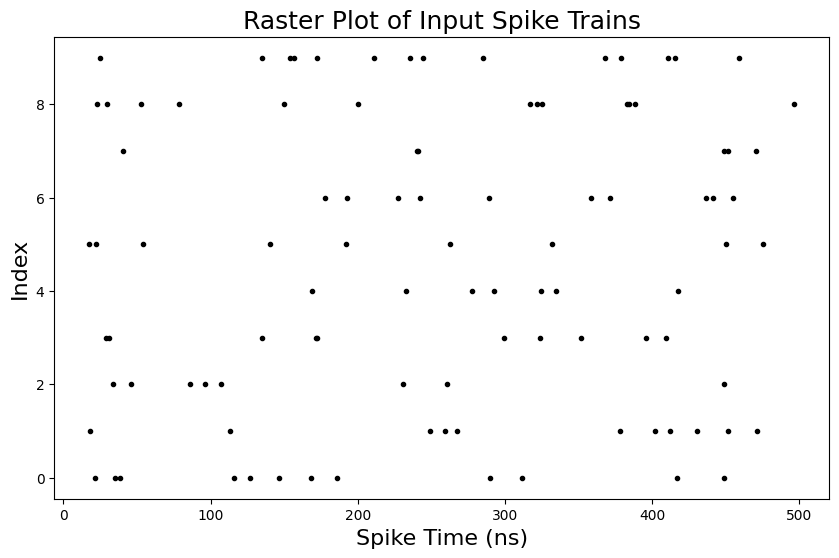

In [3]:
# random spike train for one input channel with ten spikes total over 100ns
input = SuperInput(channels=10, type='random', total_spikes=100, duration=500)
raster_plot(input.spike_arrays, title='Raster Plot of Input Spike Trains')

 - Adding the input to a neuron can be done with node methods
   - `uniform_input`: add a given spike train to all available synapses
   - `custom_input`: add a given spike train to specific synapses
   - `one-to-one`: channels and synapses of same index connected
   - `multi_channel_input`: define specific connectivity between multiple inputs and multiple synapses

In [4]:
# information about classes, methods, and functions can always be printed via
print(SuperNode.uniform_input.__doc__)


        uniform_input:
         - syntax -> SuperNode.uniform_input(SuperInput)
         - Adds the same input channel to all available synapses
         - note, the first channel of the SuperInput object will be used
        


### Simulation
- An input event creates a jump in current in the SPD synapse loop
- This causes flux to be coupled into the associated dendrite
  - In the case below, we are still using the default monosynaptic point neuron
  - Thus, the SPD synapse feeds into the soma directly
- Because here the coupling strength between the synapse and soma is 1 (by default), the shape of the SPD flux resposne can be observed as the plotted $\phi_r$ curve (flux recieved by the soma from the synapse)
-  ***Signal*** (a term from spin glass literature, but think ***membrane potential***) is integrated into the soma according to received flux
   -  The transfer function is non-trivial (though it appears so here) --> we will explore this later 

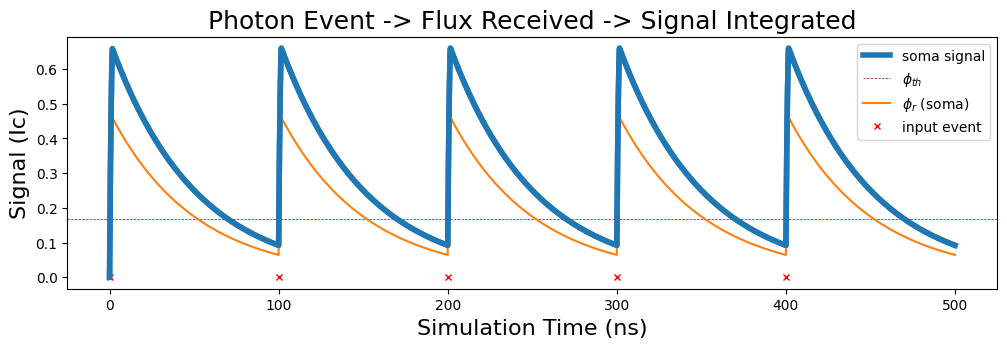

In [5]:
# spike times in nanoseconds
spike_times = np.arange(0,500,100) 

# if type=='defined': defined_spikes argument create 1-channel input object
input = SuperInput(type='defined', defined_spikes=spike_times)

# note, any neuron or dendrite parameters can be passed into the node class init
node = SuperNode(s_th=1) # large spiking threshold to avoid spiking for now

# adding input uniformly to available synapse on node's neuron
# in this case there is only one synapse attached to the somatic dendrite
node.uniform_input(input)

# create and simulate a (single node) network
net = network(
    sim   =True,            # run simulation
    tf    =input.duration,  # total duration (ns)
    nodes =[node]           # nodes in network to simulate
    )       

# plot neuron activity
title = 'Photon Event -> Flux Received -> Signal Integrated'
node.plot_neuron_activity(net,spikes=True,phir=True,input=input,title=title)


***Exercise!***
  - (1.1) Run the simulation a few times (random input spike trains will be generated each time)
    - Estimate the maximum frequency a synapse can recieve a new input event


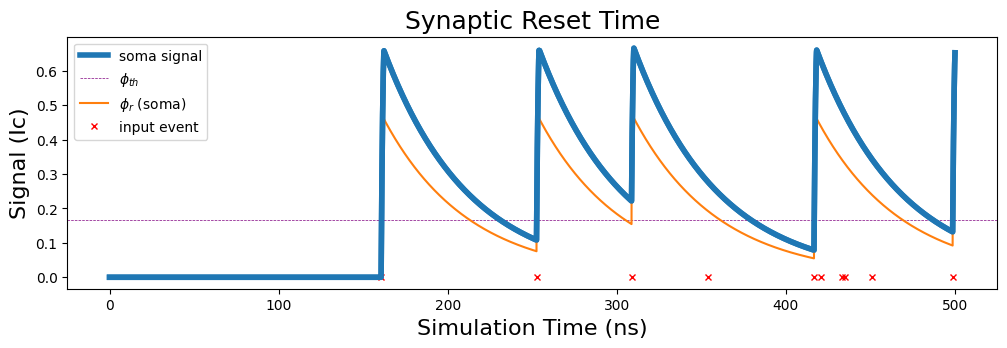

In [6]:
# random spike train for one input channel with ten spikes total over 100ns
input = SuperInput(channels=1, type='random', total_spikes=10, duration=500)

node = SuperNode(s_th=100)
node.uniform_input(input)
net = network(sim=True,dt=.1,tf=500,nodes=[node])
title = 'Synaptic Reset Time'
node.plot_neuron_activity(net,spikes=True,phir=True,input=input,title=title)

### Parameters
While there are many fabrication determined physical constants associated with a SOEN neuron, there are only three main dendritic parameters for moderating computation:

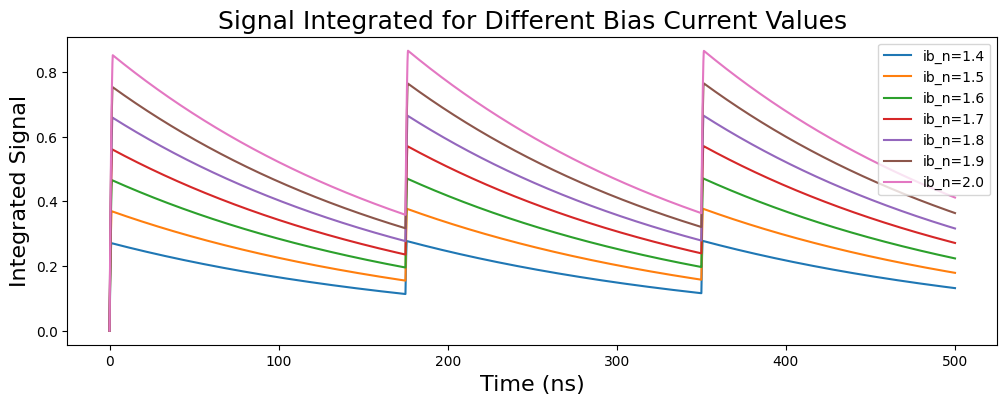

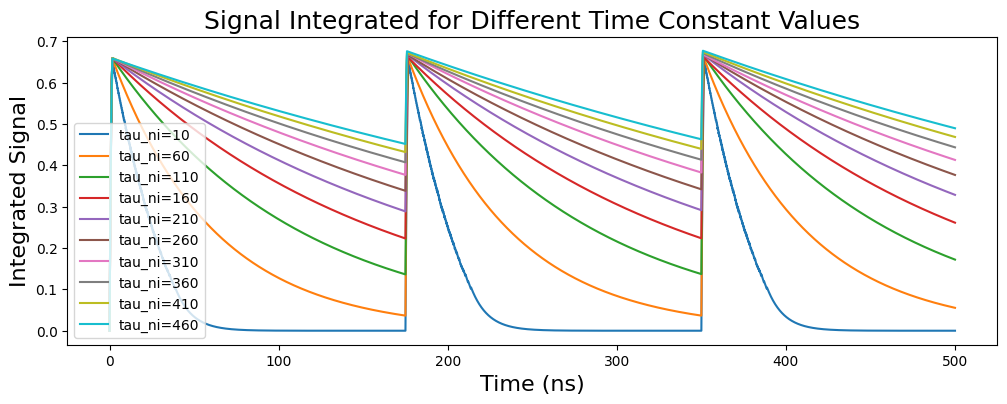

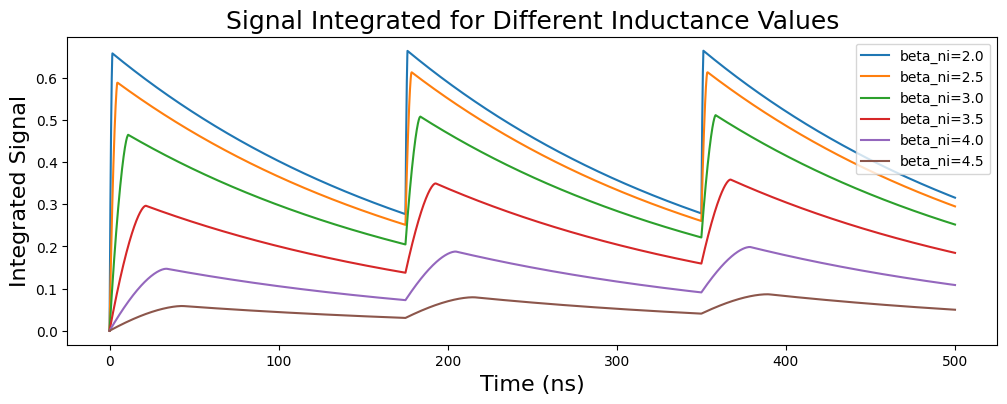

In [7]:
spike_times = np.arange(0,500,175)
input = SuperInput(type='defined', defined_spikes=spike_times)


param_lists = [
    np.arange(1.4,2.05,.1),
    np.arange(10,500,50),
    np.arange(2,5,.5)
    ]
names = ['Bias Current', 'Time Constant', 'Inductance']
code_names = ['ib_n','tau_ni','beta_ni']
for i,param_list in enumerate(param_lists):
    plt.figure(figsize=(12,4))
    for p in param_list:
        params = [1.8,200,2]
        params[i] = p

        node = SuperNode(
            s_th    = 1,                     # spiking threshold    
            ib_n    = params[0],             # bias current         
            tau_ni  = params[1],             # time constant        
            beta_ni = 2*np.pi*10**params[2], # inductance parameter 
            ) 
        node.uniform_input(input)
        net = network(sim=True,dt=.1,tf=500,nodes=[node])
        label = f"{code_names[i]}={round(p,2)}"
        plt.plot(net.t,node.neuron.dend_soma.s,label=label)
    plt.title(f'Signal Integrated for Different {names[i]} Values',fontsize=18)
    plt.xlabel('Time (ns)',fontsize=16)
    plt.ylabel('Integrated Signal',fontsize=16)
    plt.legend()
    plt.show()
    params = [1.8,400,2]

# node.plot_neuron_activity(net,ref=True,spikes=True,input=input)

***Exercise!***
 - 1.2 Play with the below node parameters 
   - In this case, these are somatic dendrite params (denoted by _ni suffix)
 - 1.3 Attempt to get zero,five, and ten output spikes for your random input spike train!
   - Best done with combinatinos of change
   - *Bonus Challenge --> Achieve 0,5,and 10 spikes while only changing one parameter at a time (holding the rest constant) for all parameters*
 - 1.4 Try to define the influence of each parameter
 - 1.5 Understand the role of the red line (refractory dendrite signal)

*Hint --> See subsequent information slide*

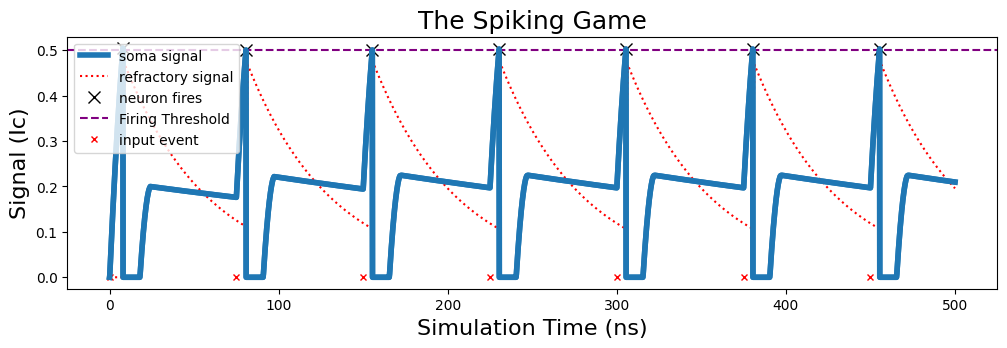

In [8]:
spike_times = np.arange(0,500,75)
input = SuperInput(type='defined', defined_spikes=spike_times)

node = SuperNode(
    s_th    = .5,           # spiking threshold    (you choose)
    ib_n    = 2.05,         # bias current         (realistically, must be between 1.4 and 2.05)
    tau_ni  = 400,          # time constant        (and positive value)
    beta_ni = 2*np.pi*1e3,  # inductance parameter (just change the exponent)
    ) 

node.uniform_input(input)
net = network(sim=True,dt=.1,tf=500,nodes=[node])
node.plot_neuron_activity(net,ref=True,spikes=True,input=input,title='The Spiking Game')

#### Simulation Method
 - $i_b$ = `ib`   = bias current (determines how much signal can be integrated into a dendrite, and strength of integration for a given amount of recieved flux)
 - $\tau$ = `tau`  = the time constant by which integrated signal can be leaked
 - $\beta$ = `beta` = determines inductor size in the integration loop (and therefore shape of integration curve)

These parameters influence signal integration for any given dendrite according to:
\begin{equation*}
\beta \frac{ds}{dt} = r(\phi,s,i_b)) - \alpha s
\end{equation*}

which is implemented in the code via the forward euler method as:
\begin{equation*}
s_{t+1} = s_t(1-\Delta t\frac{\alpha}{\beta}+\frac{\Delta t}{\beta} r(\phi,s,i_b))
\end{equation*}

Note that all dendrites have these parameters and all dendrites integrate signal.  We use the `_ni` suffix for the somatic dendrite specifically and the `_di` for all arbor dendrites.

The rate array function $r(\phi,s,i_b)$ refers to a pre-derived three-dimensional surface defined by: 
 - $s$ = accumulated signal in the dendritic integreation loop at the previous time step
 - $\phi_r$ =  received flux via couplings into the dendritic recieving loop
 - $r_{fq}$ = flux quantum production (fluxons emmitted from receiving loop to integration loop)

`s` and `phi_r` are used to reference `r_fq`, which determines new signal to be accumulated (via fluxons) into the dendritic integration loop.  Refering to the below plot, we see that for greater values of $s$, there is less flux quantum production for the same received flux $\phi_r$.  This is because the loop approaches *saturation*.


We also see that for different values of $i_b$, greater $r_{fq}$ values can be achieved for equivalent $s$ and $\phi_r$ values because the saturation limit is rasied.

![ title](../img/rate_arrays.png)

### Saturation
***Exercise!***
 - (1.5) Run the code below and observe that signal integration approaches a limit.  Is this a balance of input/decay rate or true signal saturation.  What parameter can be changed to ensure saturation is reached?  What is the saturation value (max integrateable signal)?
   - **hint -> We want to be sure that the signal is not simply leaking at about the same frequency that is being integrated*

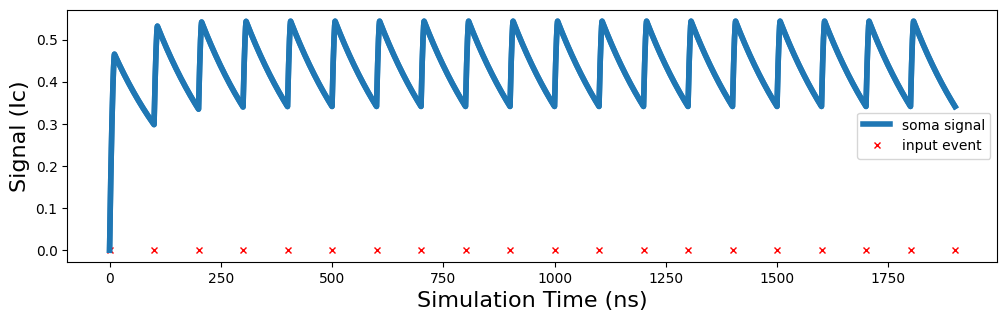

In [9]:
spike_times = np.arange(0,2000,100)
input = SuperInput(channels=1, type='defined', defined_spikes=spike_times, duration=np.max(spike_times))

node = SuperNode(
    s_th    = 100,          # spiking threshold    
    ib_n    = 1.8,          # bias current         
    tau_ni  = 200,          # time constant #**10
    beta_ni = 2*np.pi*1e3,  # inductance parameter
    ) 

# all (there's only one) synapses get the same input
node.uniform_input(input)

# create and simulate (single neuron) network
net = network(sim=True,dt=.1,tf=np.max(spike_times),nodes=[node])

# plot activity
node.plot_neuron_activity(net,spikes=True,input=input)

### Rollover
- `w_sd` = coupling strength between synapse and dendrite (in this case the soma)

***Exercise!***
 - (1.6) Analyize the following plot and then run the code.  Given our new parameter, signal integration may not behave as expected as compared to a typical neurons.  Can you explain why? (y-axis = r_fq and x-axis = phi_r)
 - (1.7) Play around with different values of `ib_n` and `w_sd` for the rollover node.  Pay attention to the $\phi_{th}$ line.  What does it demarcate?

![ title](../img/phi_period.png)

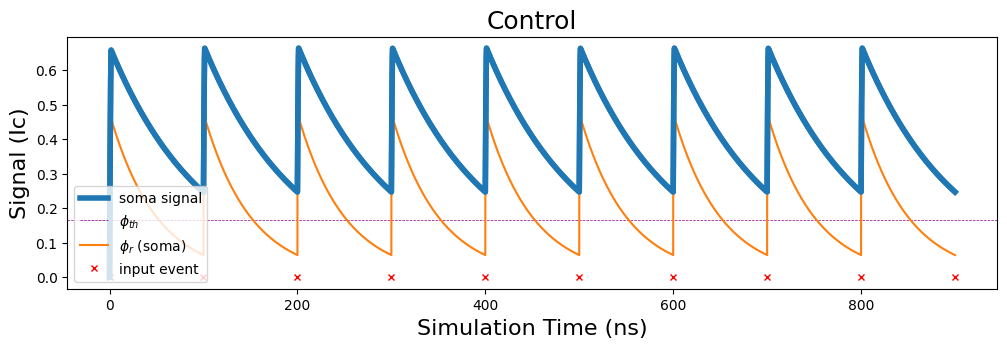

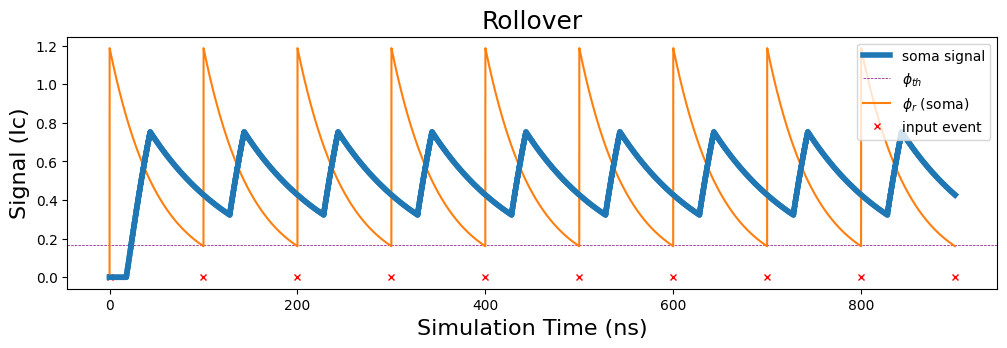

In [10]:
spike_times = np.arange(0,1000,100)
input = SuperInput(channels=1, type='defined', defined_spikes=spike_times, duration=np.max(spike_times))

# An example of a node without rollover (all same params, except w_sd)
node_control = SuperNode(s_th=1,ib_n=1.8,tau_ni=100) 
node_control.uniform_input(input)
net_control = network(sim=True,dt=.1,tf=np.max(spike_times),nodes=[node_control])
node_control.plot_neuron_activity(
    net_control,spikes=True,input=input,phir=True,ref=False,title='Control'
    )

# Rollover Node
rollover_node = SuperNode(s_th=100,tau_ni=100, # extra params
                 
    ib_n = 1.8, # bias current (must be between 1.4 and 2.05)
    w_sd = 2.5, # determines coupling strength of synapse to dendrite

    ) 

rollover_node.uniform_input(input)
rollover_net = network(sim=True,dt=.1,tf=np.max(spike_times),nodes=[rollover_node])
rollover_node.plot_neuron_activity(
    rollover_net,spikes=True,input=input,phir=True,ref=False,title="Rollover"
    )

![ title](../img/phi_period.png)

## Part 2: Dendritic Arbors
 - Biological neurons are much more than a soma and a synapse!
 - SOEN neurons therefore incorporate potentially large dendritic structures
 - This allows for complex computations to occur at the single neuron level!

### Building Structure
 - Using `SuperNode`, arbitrary dendritic trees (or arbors) can be built
 - Simply pass in a `weights` argument and a dendritic tree will be built with this shape
 - Each value in `weights` determines the coupling strength of that connection

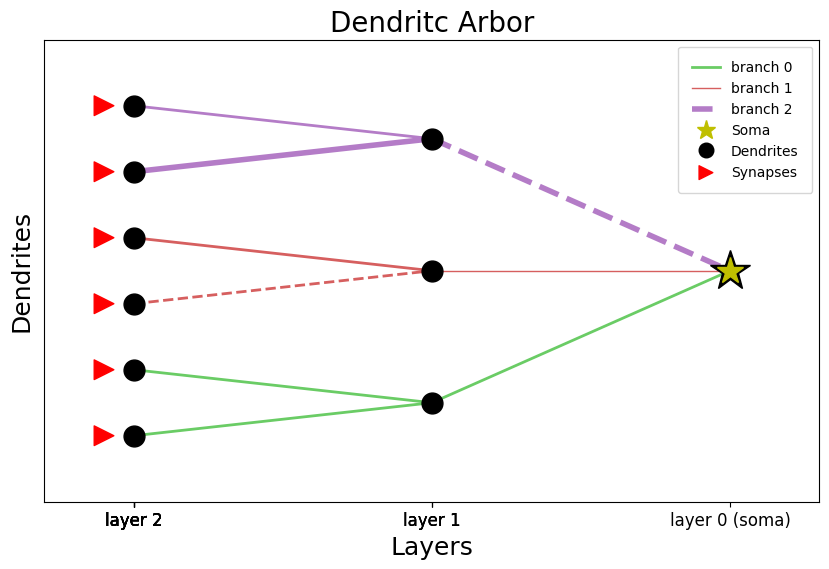

[[<sim_soens.soen_sim.dendrite object at 0x000001E70BAF21D0>]]
[[<sim_soens.soen_sim.dendrite object at 0x000001E73F3B6E60>, <sim_soens.soen_sim.dendrite object at 0x000001E73F3B6E30>, <sim_soens.soen_sim.dendrite object at 0x000001E73F3B6200>]]
[[<sim_soens.soen_sim.dendrite object at 0x000001E75173F610>, <sim_soens.soen_sim.dendrite object at 0x000001E75173EC80>], [<sim_soens.soen_sim.dendrite object at 0x000001E70B753DC0>, <sim_soens.soen_sim.dendrite object at 0x000001E70B753FD0>], [<sim_soens.soen_sim.dendrite object at 0x000001E70B751060>, <sim_soens.soen_sim.dendrite object at 0x000001E70B750F40>]]


In [11]:
# define weights, 
weights = [
    [[0.4,.3,-.8]],              # first layer, 1 group, 3 dendrites
    [[.5,.5],[-.5,.5],[.9,.5]]  # second layer, 3 groups, 2 dendrites in each group
    ]

# SuperNode will construct a neuron with this dendritic structure
node = SuperNode(weights=weights)

# Check the structure is as intended!
node.plot_structure()

# SuperNode.dendrites is a list of lists in the form of `weights`, containing dendrites
# IMPORTANT: SuperNode.dendrites has automatically added the soma-dendrite to the 0th layer
for lay in node.dendrites:
    print(lay)

In [12]:
# To access dendrites from outside the node, index accordingly
# [layer][group][dendrite]
print(node.dendrites[2][1][0].name)

# Remember the soma is at 0-0-0
print(node.dendrites[0][0][0].name)

rand_neuron_64469_lay2_branch1_den0
rand_neuron_64469_soma


*Exercise!*
 - (2.1) Build a neuron with a structure of 3 dendrites in the first layer, and a different number of dendrites feeding into each of the first layer dendrites from the second payer.

### Synaptic Structure
 - Mostly, we would like to simply use the default synaptic layer at the outermost dendrite of the tree
 - However, if custom synaptic structure are desired, a list of arbor structure (now including one extra preceding layer for the soma) can be included to define synapse locations.  One structure per synapse.

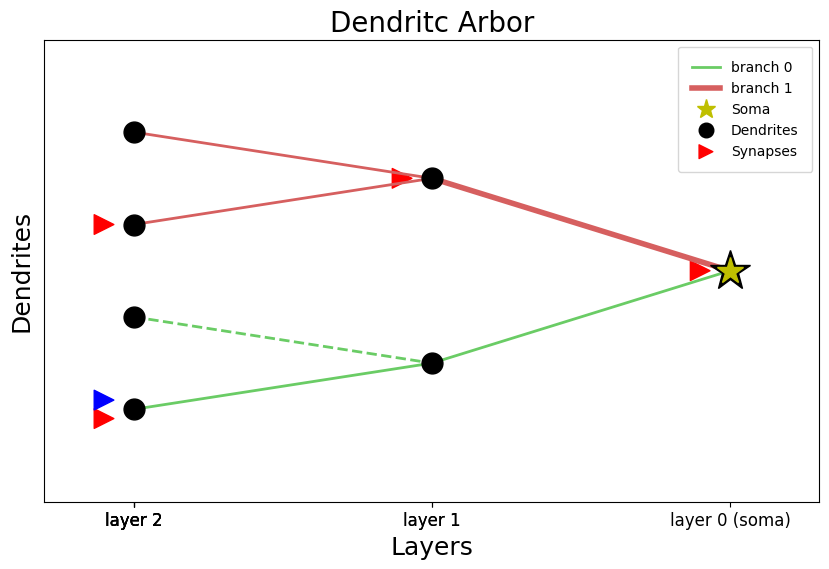

In [30]:
weights = [
    [[0.4,.8]],
    [[.5,-.5],[.5,.5]]
    ]

syn_struct = [

    [[[0]],
    [[0,0]],
    [[1,0],[0,0]]],

    [[[0]],
    [[0,0]],
    [[-1,0],[0,0]]],

    [[[0]],
    [[0,0]],
    [[0,0],[1,0]]],

    [[[0]],
    [[0,1]],
    [[0,0],[0,0]]],

    [[[1]],
    [[0,0]],
    [[0,0],[0,0]]],

]

node = SuperNode(
    weights=weights,
    synaptic_structure=syn_struct
    )

node.plot_structure()

{'uid': 115, 'unique_label': 'd115', 'ib_ramp': False, 'name': 'rand_neuron_15081_lay2_branch1_den1', 'pri': False, 'offset_trj': [], 'loops_present': 'ri', 'circuit_betas': [1.5707963267948966, 1.5707963267948966, 628.3185307179587], 'ib': 1.802395858835221, 'ib_di': 1.802395858835221, 'ib_max': 2.0523958588352214, 'tau_di': 250, 'beta_di': 628.3185307179587, 'Ic': 100, 'beta_c': 0.3, 'normalize_input_connection_strengths': False, 'total_excitatory_input_connection_strength': 1, 'total_inhibitory_input_connection_strength': -0.5, 'offset_flux': 0, 'self_feedback_coupling_strength': 0, 'rollover': 0, 'valleyedout': 0, 'doubleroll': 0, 'w_sd': 1, 'random_syn': False, 'weights': [[[0.4, 0.8]], [[0.5, -0.5], [0.5, 0.5]]], 'synaptic_indices': [[0, 0, 0], [1, 0, 0], [2, 1, 1]], 'synaptic_strengths': [0.9, 1, 0.8], 'params': {'w_sd': 1, 'random_syn': False, 'weights': [[[0.4, 0.8]], [[0.5, -0.5], [0.5, 0.5]]], 'synaptic_indices': [[0, 0, 0], [1, 0, 0], [2, 1, 1]], 'synaptic_strengths': [0.9,

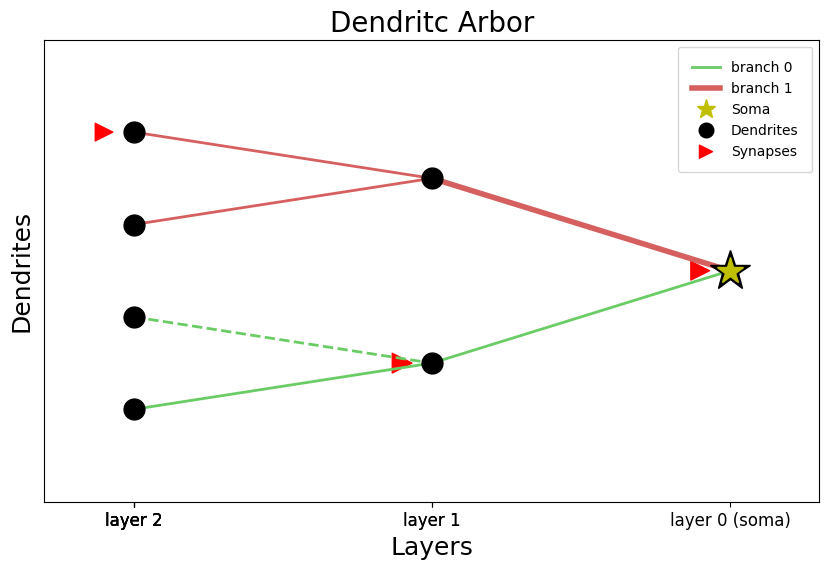

In [14]:
weights = [
    [[0.4,.8]],
    [[.5,-.5],[.5,.5]]
    ]
s_indices = [
    [0,0,0],
    [1,0,0],
    [2,1,1]
]
s_strengths = [.9,1,.8]


node = SuperNode(
    weights=weights,
    synaptic_indices=s_indices,
    synaptic_strengths=s_strengths
    )

print(node.dendrites[2][1][1].__dict__)
node.plot_structure()


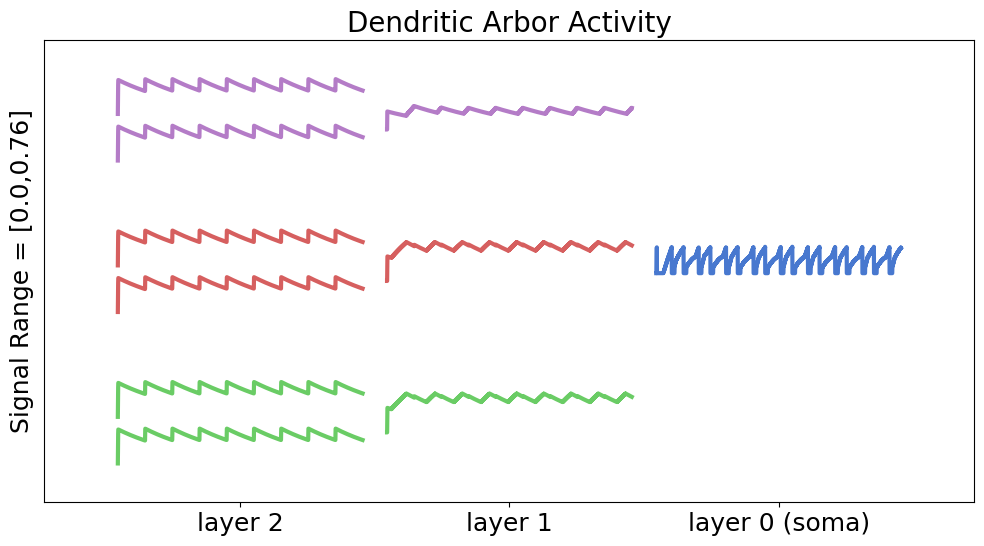

In [15]:
spike_times = np.arange(0,1000,100)
input = SuperInput(channels=1, type='defined', defined_spikes=spike_times, duration=np.max(spike_times))
weights = [
    [[0.4,.3,.2]],
    [[.5,.5],[.5,.5],[.9,.5]]
    ]
node = SuperNode(weights=weights)
node.uniform_input(input)
net = network(sim=True,dt=.1,tf=np.max(spike_times),nodes=[node])
node.plot_arbor_activity(net)

### Logic Gates
***Exercise!***
 - (3.1) Try inventing an AND gate such that the neuron only fires when receiving input at both synapses simultaneously
 - (3.2) Now try inventing the XOR gate! **Hint*, you will have to apply the concepts of inhibiton, refraction, and negative spikes to do this cleanly (one spike per truth value).

Output spike times:  [ 52. 502.]


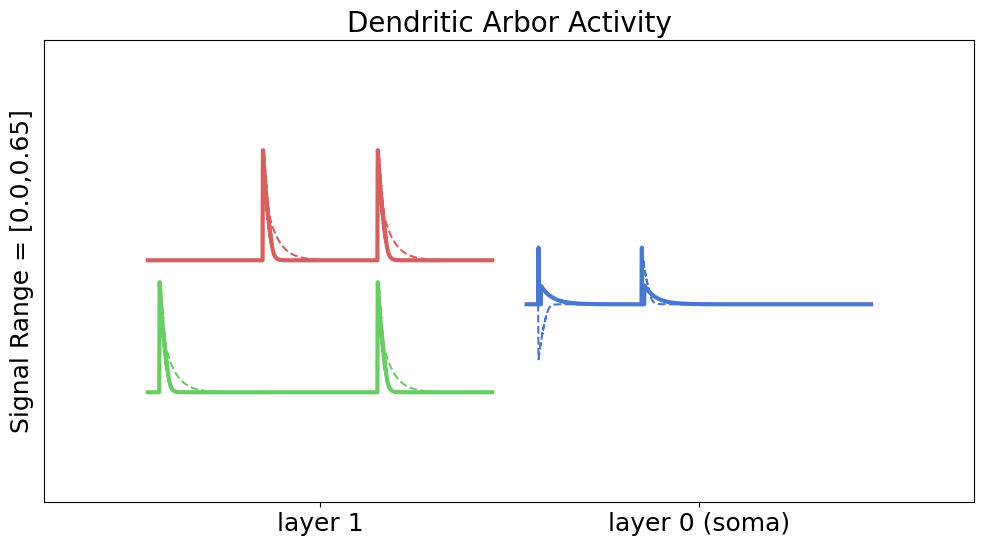

In [16]:
times = [50,500,1000,1000]
indices = [0,1,0,1]
def_spikes = [indices,times]
input = SuperInput(channels=2, type='defined', defined_spikes=def_spikes, duration=400)
# from soen_plotting import raster_plot
# raster_plot(input.spike_arrays)

# weights = [
#     [[0.4,.4]],
#     ]
# taus = [
#     [[10,10]],
#     ]
weights = [
    [[-.5,.5]],
    ]
taus = [
    [[10,10]],
    ]

connect = [[0,0],[1,1]]


# synaptic layer automatically draped over outer-most dendrites
node = SuperNode(s_th=.33,weights=weights,taus=taus,ib_ref=1)
node.multi_channel_input(input,connect)
net = network(sim=True,dt=.1,tf=1500,nodes=[node])
print("Output spike times: ",net.spikes[1])
# node.plot_neuron_activity(net,phir=True,legend=True) # useful for XOR
node.plot_arbor_activity(net,phir=True)

### 9-Pixel Classifier

Here is an analitic solution to the 9 pixel probelm, using the dendrtic structure of a single SOENs neuron.  Note, that OR-gates are achieved with with a different type of dendrite that has a flat-top response (same signal integrated for 1 or 2 inputs).

![ title](../img/9pixel.png)

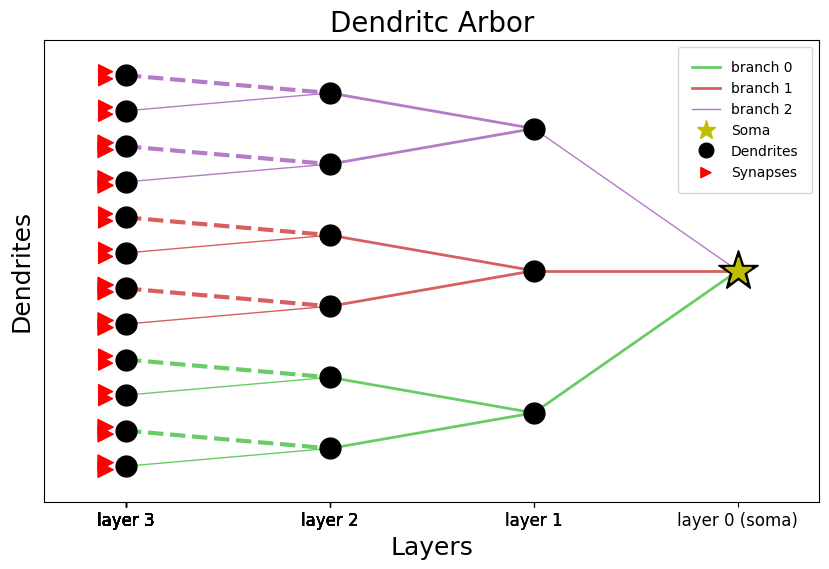

In [17]:
from sim_soens.soen_utilities import dend_load_arrays_thresholds_saturations

# load backend dendrite parameters
d_params_ri = dend_load_arrays_thresholds_saturations('default_ri')
d_params_rtti = dend_load_arrays_thresholds_saturations('default_rtti')

# use bias current from the values for which rate arrays have been generated
ib__list__ri = d_params_ri['ib__list']
ib__list__rtti = d_params_rtti['ib__list']

params = {
    'weights': [
        [[.5,.4,.3]],
        [[0.5,0.5],[0.5,0.5],[0.5,0.5]],
        [[0.35,-0.65],[0.35,-0.65],[0.35,-0.65],[0.35,-0.65],[0.35,-0.65],[0.35,-0.65]]
    ],
    'taus': [
        [[10,150,1000]],
        [[250,250],[250,250],[250,250]],
        [[250,250],[250,250],[250,250],[250,250],[250,250],[250,250]]
    ],
    'biases': [
        [[3,3,3]],
        [[5,5],[5,5],[5,5]],
        [[-4,3],[-4,3],[-4,3],[-4,3],[-4,3],[-4,3]]
    ],
    'types': [
        [['rtti','rtti','rtti']],
        [['ri','ri'],['ri','ri'],['ri','ri']],
        [['rtti','ri'],['rtti','ri'],['rtti','ri'],['rtti','ri'],['rtti','ri'],['rtti','ri']]
    ],
    'syns': [['2','5'],['4','6'],['5','8'],['4','6'],['1','3'],['7','9'],
             ['4','6'],['2','5'],['7','9'],['1','3'],['4','6'],['5','8']],
    'syn_w': [[.6,.6],[.5,.5],[.6,.6],[.5,.5],[.6,.6],[.5,.5],
              [.6,.6],[.5,.5],[.6,.6],[.5,.5],[.6,.6],[.5,.5]],
       
    # "ib_ne": ib__list__ri[4],
    "tau_di": 250,
    "ib_n": ib__list__ri[4], 
    "beta_ni": 2*np.pi*1e2,
    "tau_ni": 50,
    "w_sd": 1,
    "ib_ref": ib__list__ri[8], 
    "beta_ref": 2*np.pi*1e2,
    "tau_ref": 50,
    'ib_list_ri':ib__list__ri[:],
    'ib_list_rtti':ib__list__rtti[:],
}

# create a neuron with this structure and parameters
nine_neuron = SuperNode(s_th=.1,**params) 
nine_neuron.plot_structure()

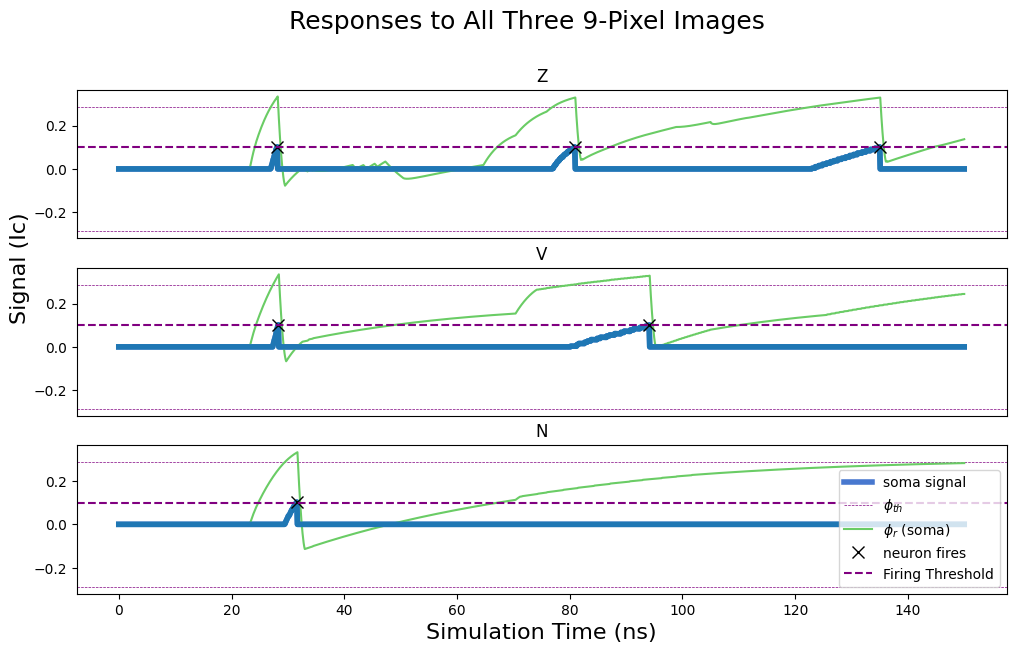

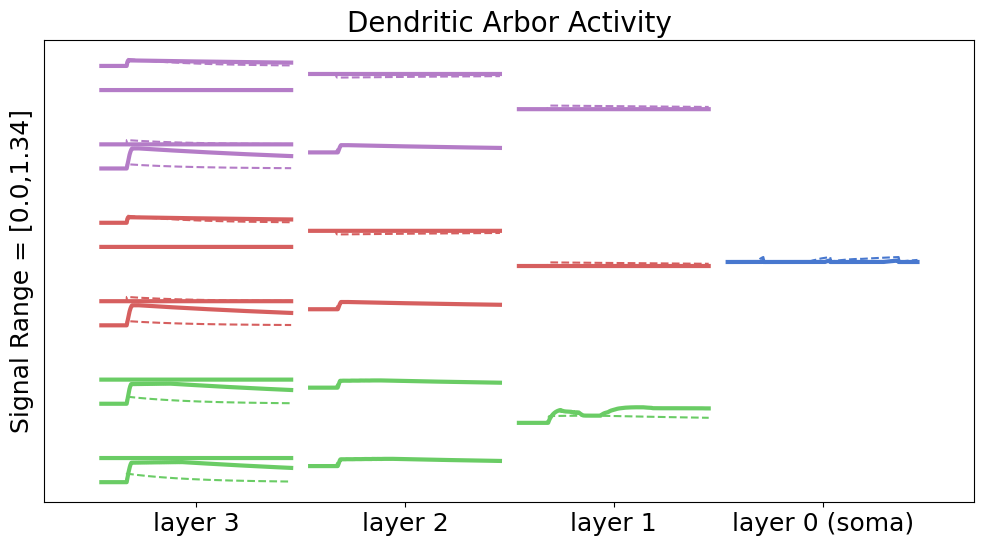

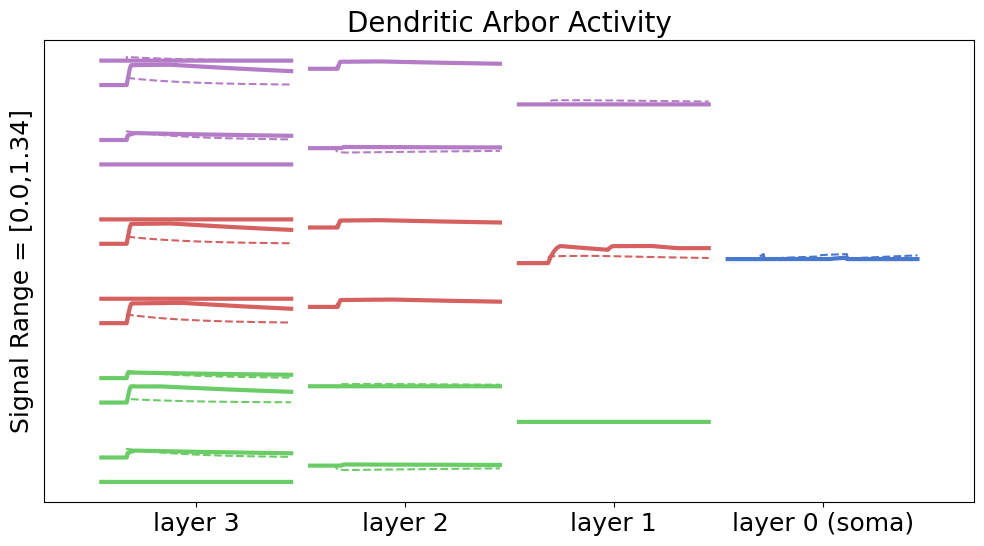

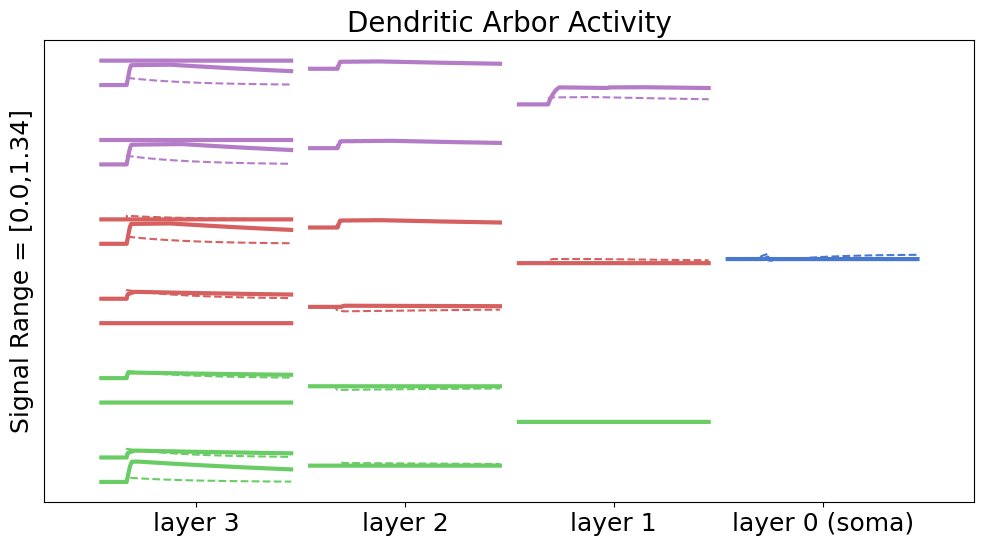

In [18]:

z = np.array([0,1,4,7,8]) # z-pixel array
v = np.array([0,3,2,5,7]) # v
n = np.array([1,3,5,6,8]) # n
letters = [z,v,n]

run_neurons = []

for let in letters:
    nine_neuron = SuperNode(s_th=.1,**params) 
    indices = let
    times = np.ones(len(indices))*20
    def_spikes = [indices,times]
    input = SuperInput(channels=9, type='defined', defined_spikes=def_spikes, duration=100)
    # raster_plot(input.spike_arrays)
    count = 0
    for g in nine_neuron.synapses:
        for s in g:
            for i,row in enumerate(input.spike_rows):
                if i == int(s.name)-1:
                    s.add_input(input.signals[i])
                    count+=1
    run_neurons.append(nine_neuron)

net = network(sim=True,dt=.1,tf=150,nodes=run_neurons,new_way=True)

title = 'Responses to All Three 9-Pixel Images'
subtitles =['Z','V','N']
activity_plot(run_neurons,net,dend=False,phir=True,size=(12,8),title=title,subtitles=subtitles)

for n in run_neurons:
    n.plot_arbor_activity(net,phir=True)

## Part 3: Plasticity
SOENs host a number of plasticity mechanisms through which the effective weight (a combination of coupling strength and bias current) between components can be moderated in real time any of the following methods:
 - Top down supervision
 - Automated hardware-in-the-loop
 - On-chip circuits responding to real-time local states

Today, we will explore the most straightforward of our plasticity knobs--*flux offset*, which simply couples additional flux (positive of negative) to the receiving loop of a component such that for the same input relationship, different responses can be achieved.  Essentially, the 'weight' between components can be tuned.

Below is a neuron with one synapse, one arbor-dendite, and a soma.  The dendrites flux is offset with different phi values.  Observe how this changes the *dendrite's* integrated signal.

*Exercise!*
 - (3.1) Run the cell and observe the inegrated signal for the dendrite. How do you predict this will change the integrated signal of the soma?  Plot to confirm.
 - (3.2) How will bias current moderate this change?  What are the total contributions to effective weight?  Try plotting different combinations.

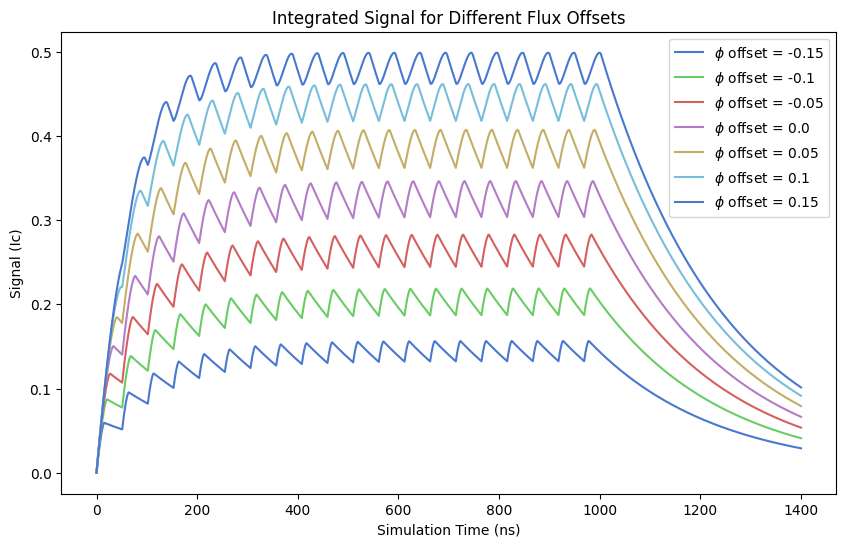

In [19]:
times = np.arange(0,1000,51)
input = SuperInput(channels=1, type='defined', defined_spikes=times)

weights = [[[0.5]]]

mono_dend = SuperNode(weights=weights,s_th=1,beta_di=2*np.pi*1e4,tau_di=250,ib_n=1.8)
mono_dend.uniform_input(input)

plt.figure(figsize=(10,6))
PHI = np.arange(-.15,.16,.05)
for phi in PHI:
    mono_dend.dendrites[1][0][0].offset_flux = phi
    net = network(sim=True,dt=.1,tf=1400,nodes=[mono_dend])

    plt.plot(net.t,mono_dend.dendrites[1][0][0].s,label=f'$\phi$ offset = {np.round(phi,2)}')
    plt.legend()

plt.xlabel("Simulation Time (ns)")
plt.ylabel("Signal (Ic)")
plt.title("Integrated Signal for Different Flux Offsets")
plt.show()

### Learning!

In [20]:

def make_letters():

    # non-noisy nine-pixel letters
    letters = {
        'z': [1,1,0,
              0,1,0,
              0,1,1],

        'v': [1,0,1,
              1,0,1,
              0,1,0],

        'n': [0,1,0,
              1,0,1,
              1,0,1]
    }

    return letters

def plot_letters(letters):
    import matplotlib.cm as cm
    fig, axs = plt.subplots(1, len(letters),figsize=(12,6))
    for  j,(name,pixels) in enumerate(letters.items()):
        arrays = [[] for i in range(3)]
        count = 0
        for col in range(3):
            for row in range(3):
                arrays[col].append(pixels[count])
                count+=1
        pixels = np.array(arrays).reshape(3,3)

        axs[j].set_xticks([])
        axs[j].set_yticks([])
        axs[j].set_title(name)
        axs[j].imshow(
            pixels,
            interpolation='nearest',
            cmap=cm.Blues
            )
    plt.show()

def make_inputs(letters,spike_time):
    # make the input spikes for different letters
    inputs = []
    for name, pixels in letters.items():
        idx = np.where(np.array(letters[name])==1)[0]
        spike_times = np.ones(len(idx))*spike_time
        defined_spikes=[idx,spike_times]
        inputs.append(SuperInput(type='defined',defined_spikes=defined_spikes))
    return inputs

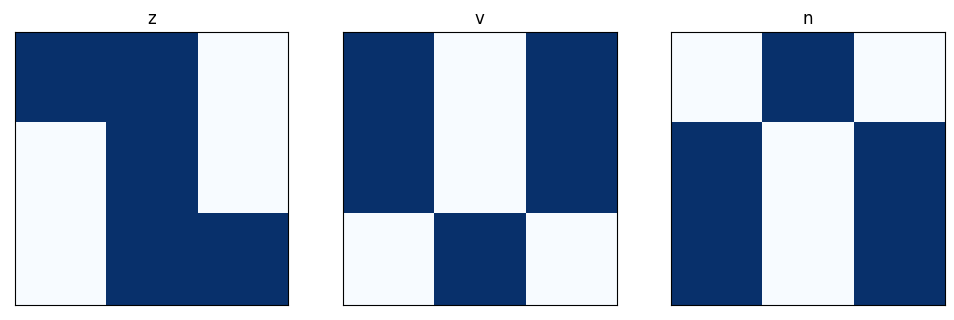

In [21]:
letters=make_letters()
inputs = make_inputs(letters,20)
plot_letters(letters)

Training Z-neuron.  
Desired output = [5, 0, 0]

Run    Spikes
       [z, v, n]
0      [1, 1, 1]
5      [1, 1, 0]
10     [0, 1, 1]
15     [2, 2, 2]
20     [1, 1, 9]
25     [0, 8, 8]
30     [1, 2, 5]
Converged! (on run 32)
Spikes = [0, 2, 4]


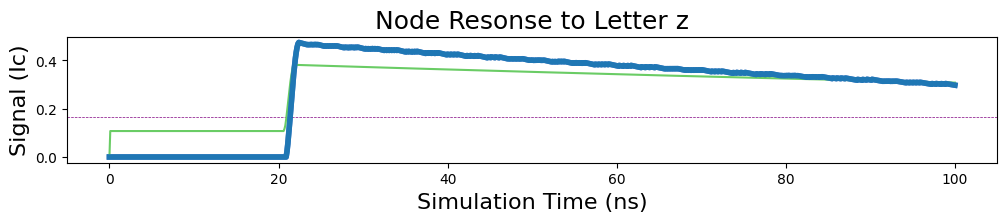

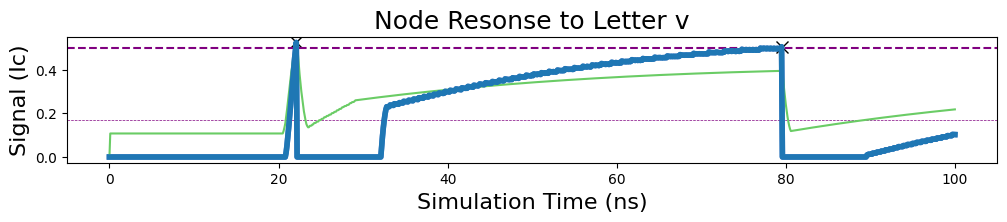

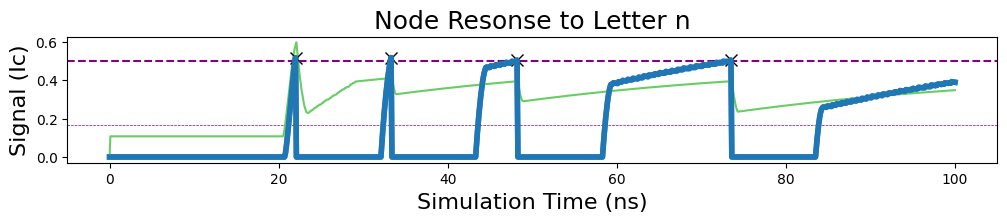

In [22]:
def single_9pixel_classifier(inputs,expect,learning_rate):
    import copy
    # make the neuron (initialize within dynamical range)
    weights = [
        [[.5,.5,.5]],
        [[.3,.3,.3],[.3,.3,.3],[.3,.3,.3]]
    ]
    node_z = SuperNode(weights=weights)


    # track flux offset trajectories for each dendrite
    offsets = {}
    for dend in node_z.dendrite_list:
        if 'ref' not in dend.name:
            offsets[dend.name] = []


    print("Training Z-neuron.  \nDesired output = [5, 0, 0]\n")
    print("Run    Spikes")
    print("       [z, v, n]")


    # give plenty of runs to converge
    for run in range(300):

        # track total error for each letter
        total_error=0
        plots = []
        act_plots = []
        spikes = []
        run_copies = []
        net_copies = []
        # iterate over each letter
        for i,input in enumerate(inputs):
            node_z.one_to_one(input)

            # run the simulation and count the spikes
            net = network(sim=True,dt=.1,tf=100,nodes=[node_z])
            out_spikes = net.spikes[1]
            spikes.append(len(out_spikes))

            # copy states of nodes for later plotting if converged
            run_copies.append(copy.deepcopy(node_z))
            net_copies.append(copy.deepcopy(net))


            # check the difference of expectation and output for this letter
            error = expect[i] - len(out_spikes)

            # add error to total error
            total_error+=np.abs(error)

            # reset spike times
            node_z.neuron.spike_times=[]

            # adjust dendrite flux offset
            # function of error, activity, and learning rate
            for dend in node_z.dendrite_list:
                if 'ref' not in dend.name:
                    step = error*np.mean(dend.s)*learning_rate
                    dend.offset_flux += step
                    offsets[dend.name].append(dend.offset_flux)

        # print spiking output for each letter every ten runs
        if run%5==0: 
            print(run," "*(5-len(str(run))),spikes)

        # if error for all three letters is zero, break and plot the victory!
        if total_error==0:
            print(f"Converged! (on run {run})")
            print(f"Spikes = {spikes}")

            # plot neuron activities
            for i,n in enumerate(run_copies):
                # n.plot_arbor_activity(net,phir=True)
                n.plot_neuron_activity(
                    net_copies[i],
                    legend=False,
                    phir=True,
                    size=(12,2),
                    title=f"Node Resonse to Letter {list(letters.keys())[i]}",
                    dend=False
                    )
                
            break
    return node_z, net_copies, run_copies, offsets

trained_neuron,net_copies,run_copies,offsets = single_9pixel_classifier(inputs,[0,2,4],.01)

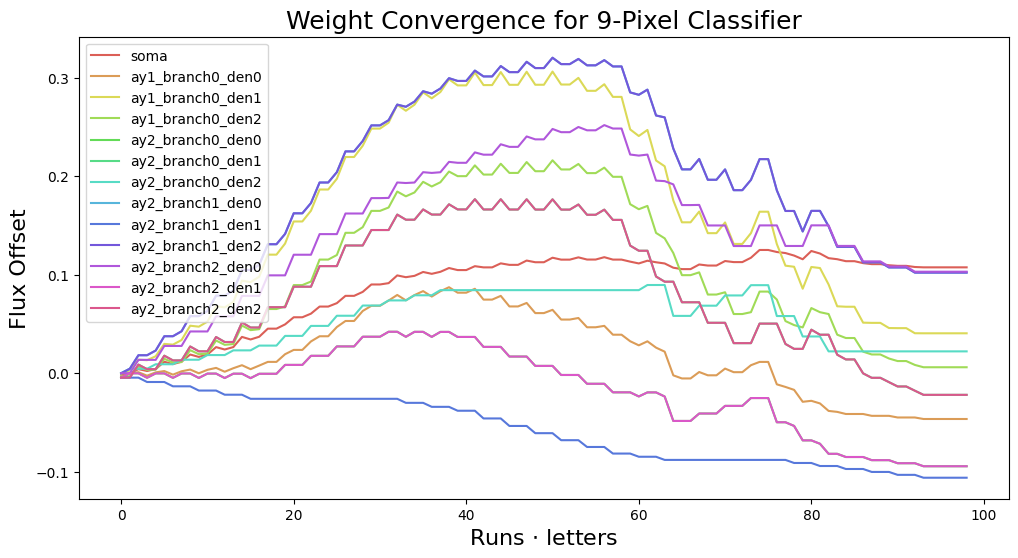

In [23]:
# Plot the offset trajectories for each dendrite to demonstrate convergence
import seaborn as sns
colors = sns.color_palette('hls', 13)

# plot trajectories of flux offsets for each dendrite
plt.figure(figsize=(12,6))
for i,(name,offset) in enumerate(offsets.items()):
    if 'soma' in name:
        name = 'soma'
    else:
        name = name[18:]
    plt.plot(offset,color=colors[i],label=name)
plt.title("Weight Convergence for 9-Pixel Classifier",fontsize=18)
plt.xlabel("Runs $\cdot$ letters",fontsize=16)
plt.ylabel("Flux Offset",fontsize=16)
plt.legend()
plt.show()

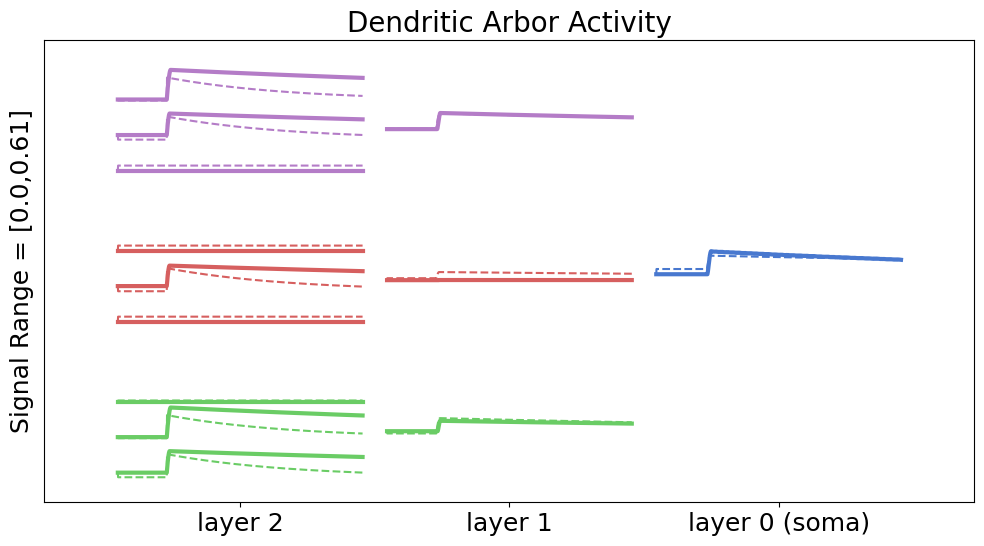

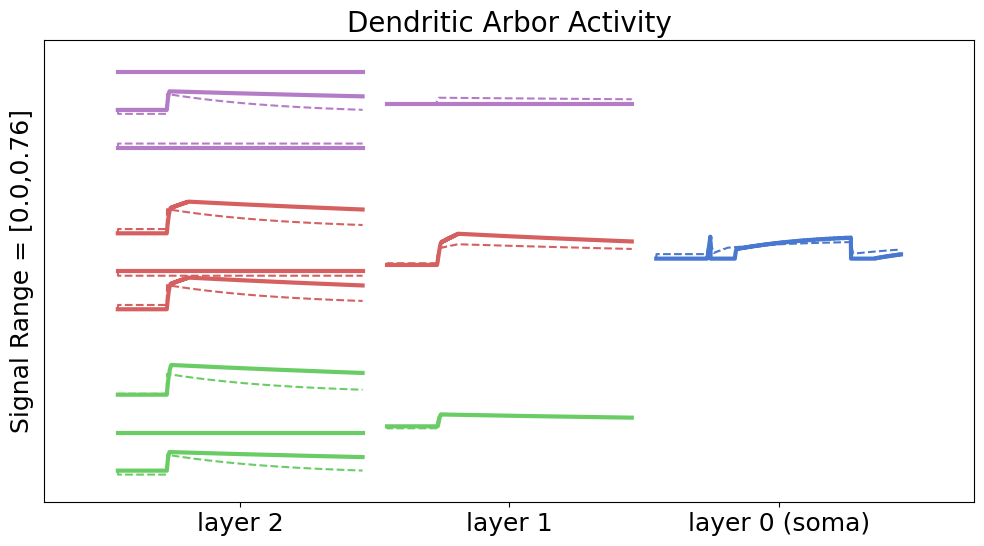

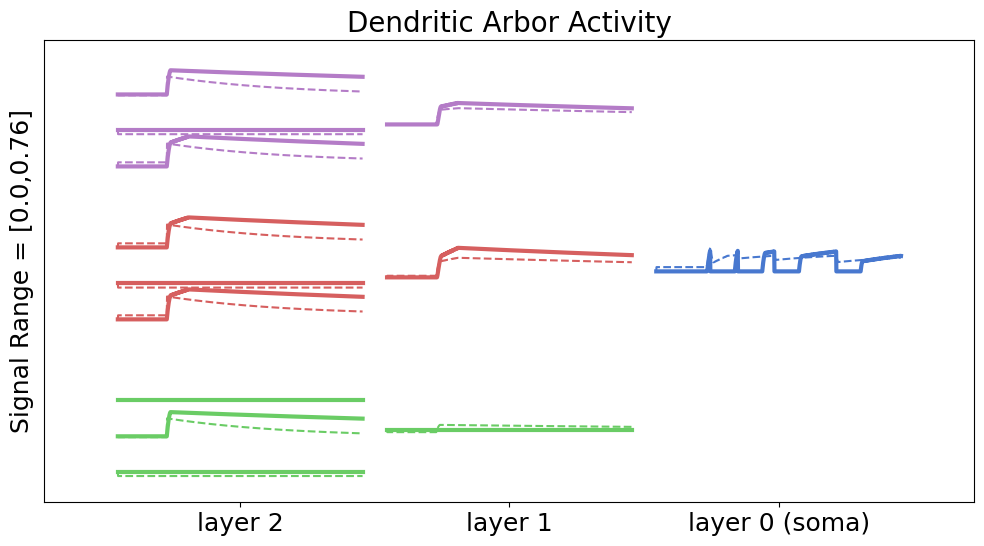

In [24]:
# plot arbor activities
for i,n in enumerate(run_copies):
    n.plot_arbor_activity(net_copies[i],phir=True)

### Part 5: Networking and Dynamics
Here is a simple reservoir example, stricly to demonstrate "networkability."
 - Saccade MNIST dataset
 - Random reservoir of point neurons
 - Linear classifier trained on network activity


Internal network connections = 55


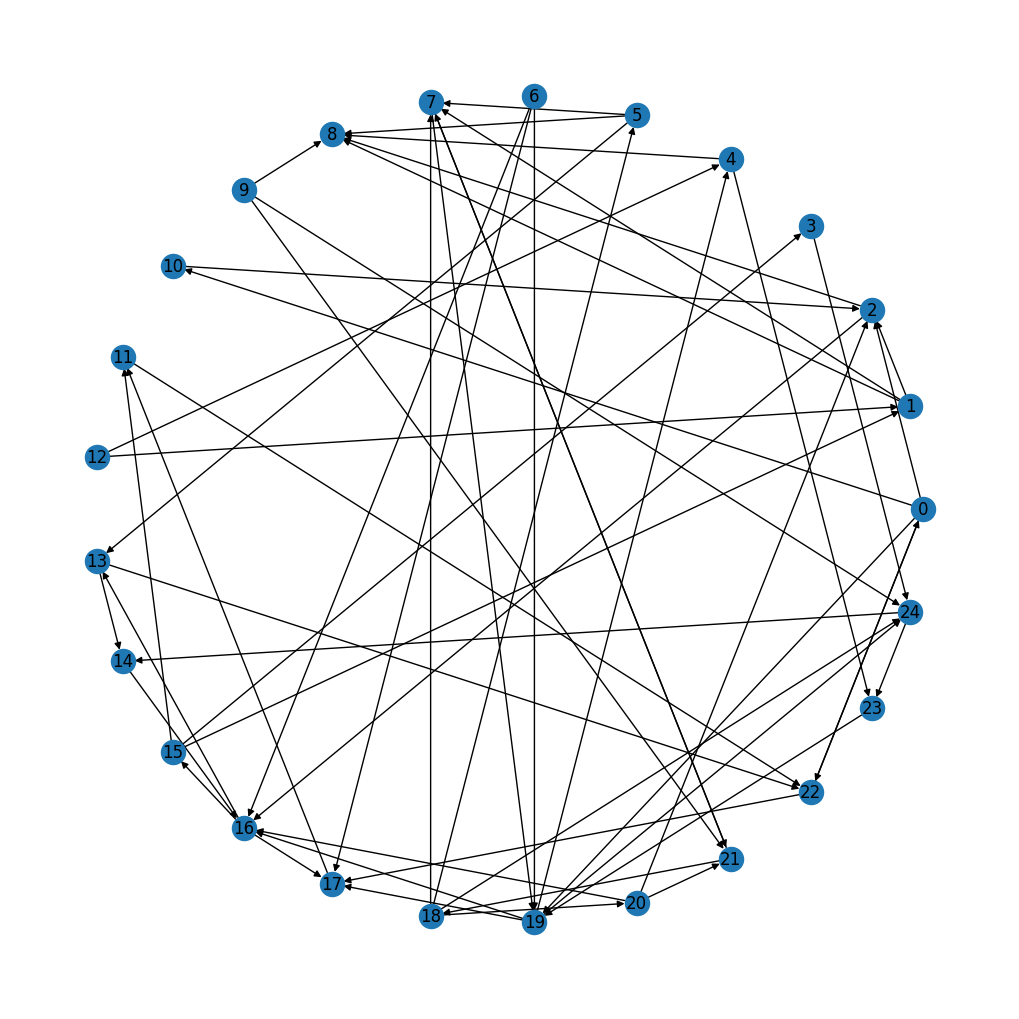

In [25]:
input = SuperInput(channels=42, type='random', total_spikes=1000, duration=500)

from sim_soens.super_net import SuperNet

l1_w = .5
l2_w = .5

net = SuperNet(

    N            = 25,
    prob_connect = 0.1,
    tf           = 500,
    dt           = 0.1,

    node_params = {
    "weights": [
    [[l1_w,l1_w]],
    [[l2_w,l2_w,l2_w],[l2_w,l2_w,l2_w]]
    ],
    "s_th": .5,
    }
)
net.graph_net()


Input network connections = 95

running network


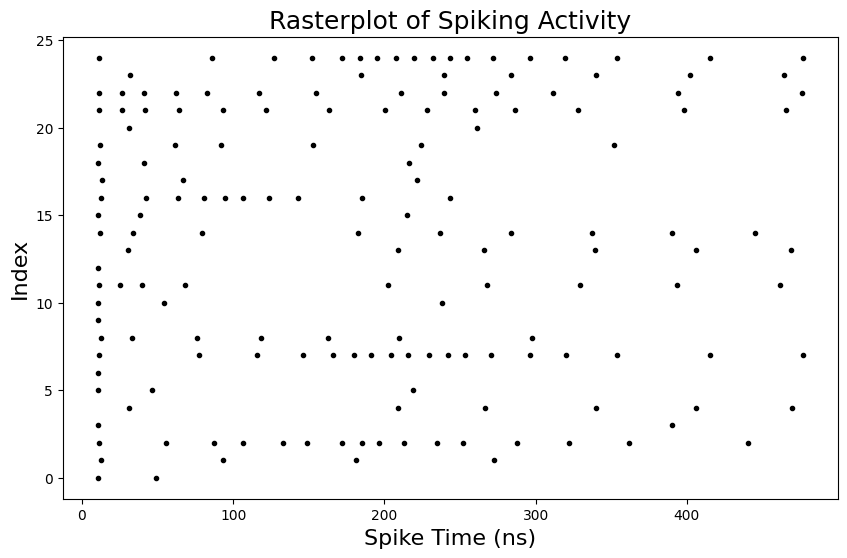

In [26]:
net.input_connect(input,prob_input=1)
net.run_network()
net.raster_plot()

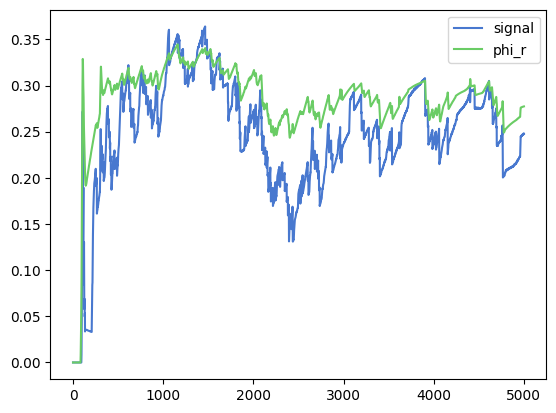

In [27]:
plt.plot(np.mean(net.net.signal,axis=0),label="signal")
plt.plot(np.mean(net.net.phi_r,axis=0),label="phi_r")
plt.legend()

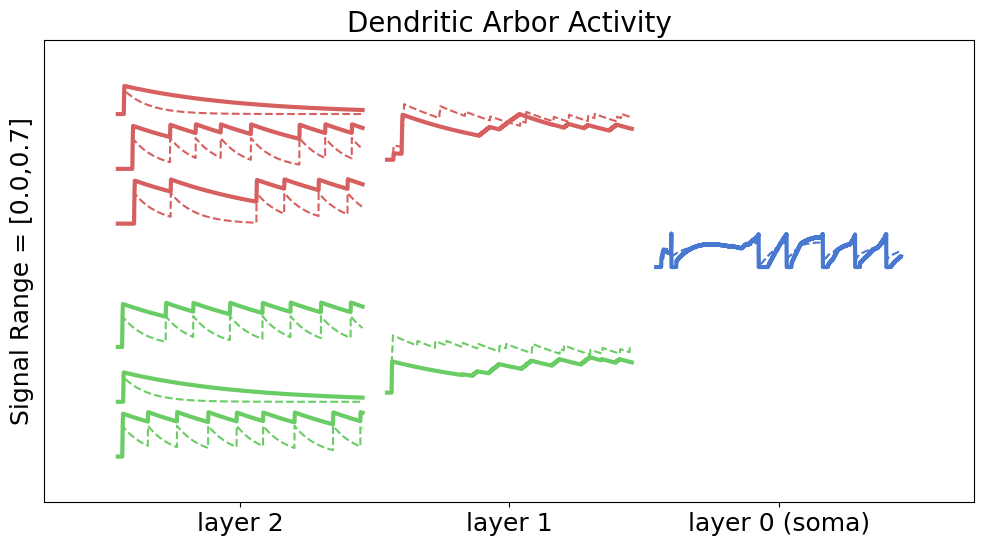

In [29]:
net.nodes[4].plot_arbor_activity(net.net,phir=True)

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


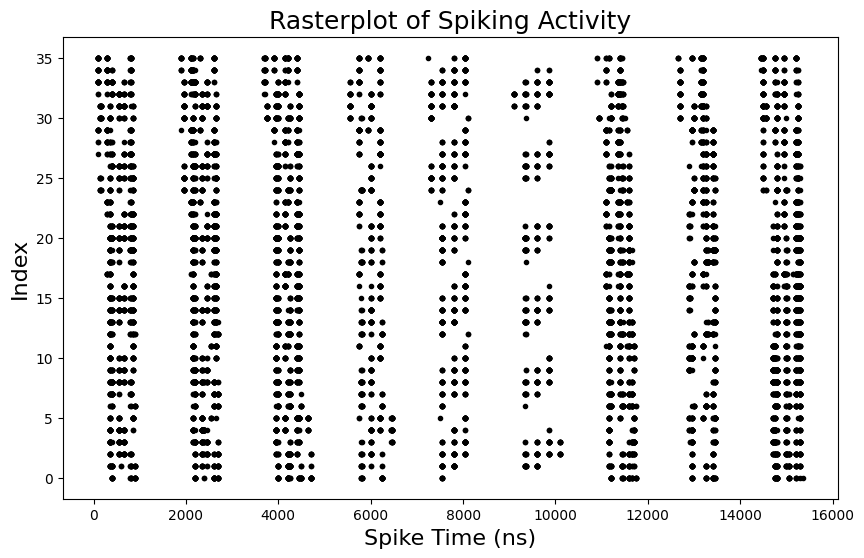

In [ ]:
# Saccade MNIST dataset
input = SuperInput(channels=36,type="saccade_MNIST",tile_time=50)
raster_plot(input.spike_arrays)

KeyboardInterrupt: 

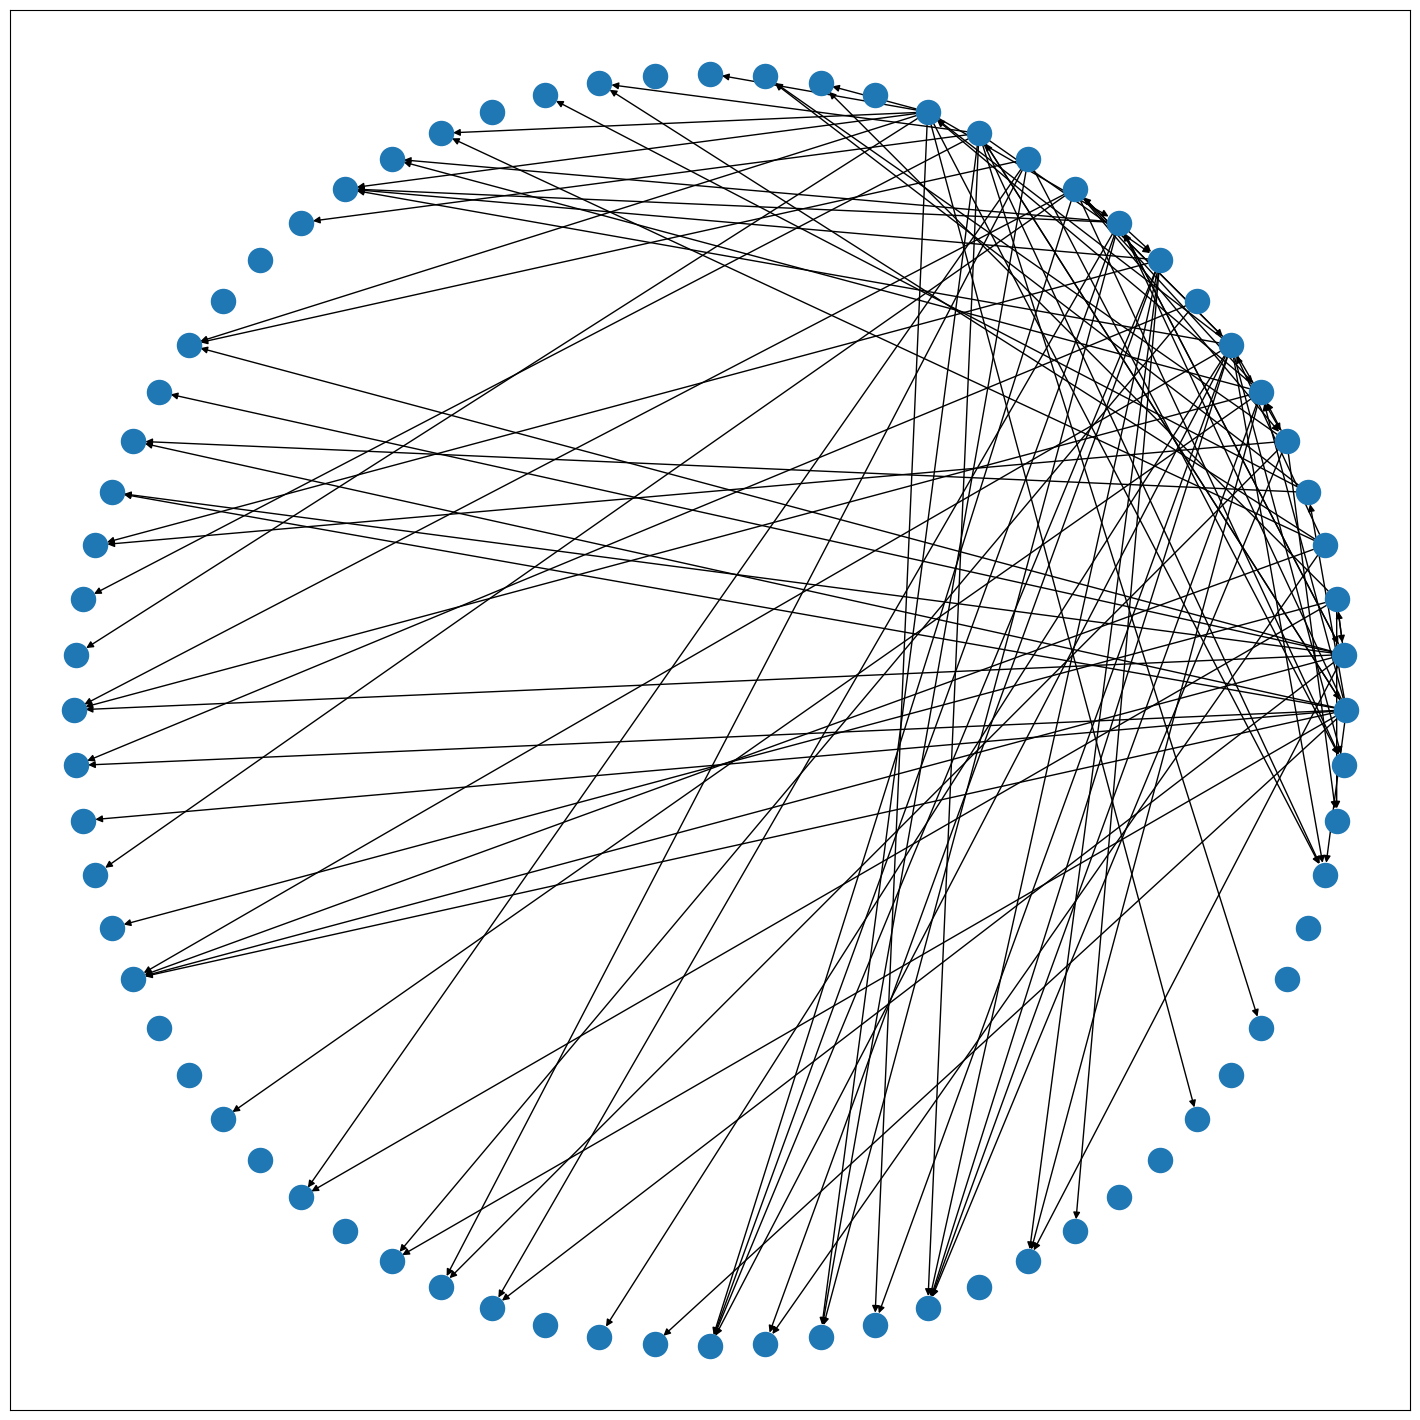

In [ ]:
# Random network of 72 neurons
from sim_soens.super_net import PointReservoir
params= {
    "N":72,
    "s_th":0.5,
    "beta":2*np.pi*10**2,
    "tau":100,
    "tau_ref":50,
    "tf":3600*5,
    "run":1,
    "laps":10,
    }

res = PointReservoir(**params)
res.graph_net()

In [ ]:
# Wire up input
res.connect_input(input)
# res.graph_input()

running network


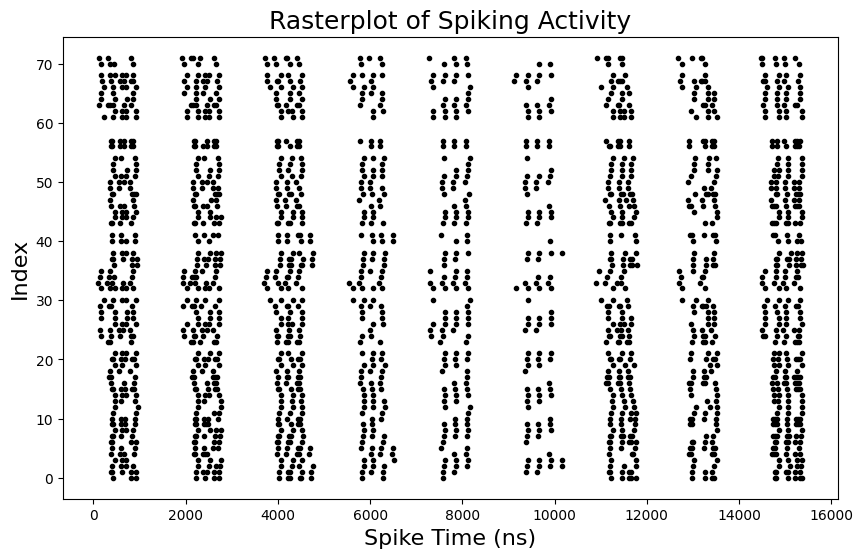

In [ ]:
# Run the network and plot activity
res.run_network()
raster_plot(res.net.spikes)

[0 1 2]  --> Classified!


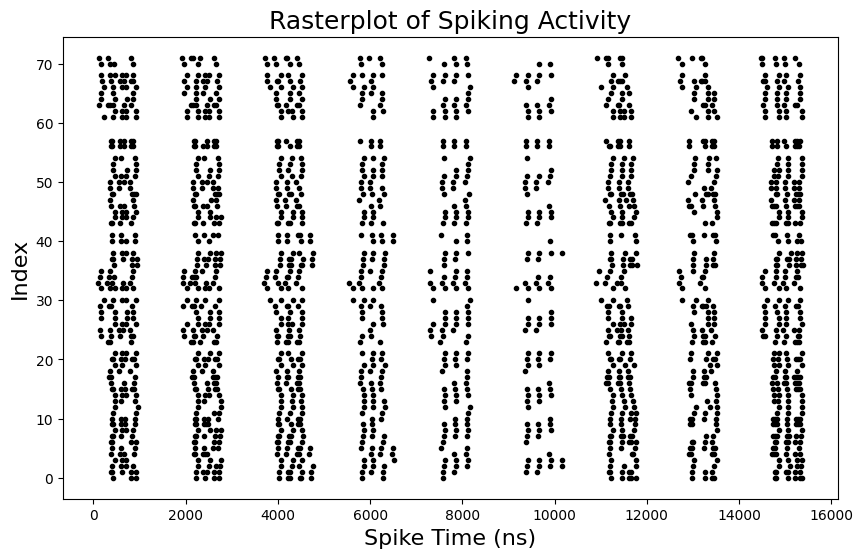

In [ ]:
# Train and test linear classifier!
from sim_soens.super_functions import *
from sklearn.linear_model import LogisticRegression
spikes = res.net.spikes
# spikes = input.spike_arrays

N = 72
T = 3601*5
classes = 3
examples_per_class = 3
samples = classes*examples_per_class
window = 360*5
labels = [0,0,0,1,1,1,2,2,2]

# spikes = net.net.spikes
mat = spks_to_binmatrix(N,T,spikes)
# raster_plot(spikes)
model = LogisticRegression(max_iter=100000)
model_fine = LogisticRegression(max_iter=100000)
X = []
y = []
X_f = []
y_f = []
for i in range(samples):
    if  i%3 != 2:
        section = mat[:,i*window:i*window+window]
        x = np.concatenate(section).reshape(1, -1)[0]
        X.append(x)
        y.append(labels[i])


model.fit(X,y)

X_test = []
y_test = []
for i in range(samples):
    if i%3 == 2:
        section = mat[:,i*window:i*window+window]
        x = np.concatenate(section).reshape(1, -1)[0]
        X_test.append(x)


predictions=model.predict(X_test)

if np.array_equal(predictions, [0,1,2]):
    print(predictions, " --> Classified!")
    raster_plot(spikes)
else:
    print(predictions)